In [1]:
import librosa,librosa.display
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
import numpy as np
import math
import os

In [2]:
DATASET_PATH = "C:\\Users\\Yasharth\\Desktop\\MajorProject\\GTZEN\\genres_original"
SAMPLE_RATE = 22050
DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION


In [3]:
def save_mfcc(dataset_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {"mapping": [], "mfcc": [], "labels": []}
    num_sample_per_segment = int(
        SAMPLES_PER_TRACK / num_segments
    )  # so here every 30 second we would split them into 5 segments
    expected_num_mfcc_vector_per_segment = math.ceil(
        num_sample_per_segment / hop_length
    )
    print(f"{expected_num_mfcc_vector_per_segment} that is the length of the sequence")

    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath != dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            for file in filenames:
                file_path = os.path.join(dirpath, file)
                try:
                    signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)
                    for s in range(num_segments):
                        start_sample = num_sample_per_segment * s
                        finish_sample = start_sample + num_sample_per_segment
                        mfcc = librosa.feature.mfcc(
                            y=signal[start_sample:finish_sample],
                            sr=SAMPLE_RATE,
                            n_mfcc=13,
                            n_fft=n_fft,
                            hop_length=hop_length,
                        )
                        mfcc = (
                            mfcc.T
                        )  # as we have the data (sequence number , number of features)
                        if len(mfcc) == expected_num_mfcc_vector_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i - 1)
                except:
                    pass

            print(f"{dirpath.split('/')[-1]} is loaded successfully")

    return data


In [4]:
data_dict = save_mfcc(DATASET_PATH, num_segments=10)

130 that is the length of the sequence
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\blues is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\classical is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\country is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\disco is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\hiphop is loaded successfully


d:\Anaconda\envs\tf-gpu-cuda8\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\jazz is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\metal is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\pop is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\reggae is loaded successfully
C:\Users\Yasharth\Desktop\MajorProject\GTZEN\genres_original\rock is loaded successfully


In [5]:
data = np.array(data_dict['mfcc'])
label = np.array(data_dict['labels']).reshape(-1,1)

In [6]:
data.shape

(9986, 130, 13)

In [7]:
label.shape

(9986, 1)

In [8]:
from sklearn.model_selection import train_test_split
X_train_val, X_test, y_train_val, y_test =train_test_split(data , label  ,test_size=0.2, shuffle = True )
X_train, X_valid, y_train, y_valid =train_test_split(X_train_val , y_train_val  ,test_size=0.2)

In [9]:
model = keras.models.Sequential([
    
    keras.layers.LSTM(128, return_sequences=True, input_shape=[None, 13]),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(64, return_sequences=True),
    keras.layers.LayerNormalization(),
    keras.layers.LSTM(32),
    keras.layers.Dense(10 ,  activation="softmax")
])

model.compile(loss ='sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam() , metrics = ['accuracy'])

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 128)         72704     
_________________________________________________________________
layer_normalization (LayerNo (None, None, 128)         256       
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 64)          49408     
_________________________________________________________________
layer_normalization_1 (Layer (None, None, 64)          128       
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense (Dense)                (None, 10)                330       
Total params: 135,242
Trainable params: 135,242
Non-trainable params: 0
__________________________________________________

In [11]:
history = model.fit(X_train , y_train , validation_data=(X_valid , y_valid) , epochs=100 , batch_size=8)

Epoch 1/100
799/799 [==============================] - 72s 90ms/step - loss: 1.6613 - accuracy: 0.3966 - val_loss: 1.4890 - val_accuracy: 0.4599
Epoch 2/100
799/799 [==============================] - 73s 92ms/step - loss: 1.4706 - accuracy: 0.4593 - val_loss: 1.5336 - val_accuracy: 0.4643
Epoch 3/100
799/799 [==============================] - 73s 91ms/step - loss: 1.3705 - accuracy: 0.5020 - val_loss: 1.3210 - val_accuracy: 0.5300
Epoch 4/100
799/799 [==============================] - 72s 90ms/step - loss: 1.2577 - accuracy: 0.5437 - val_loss: 1.2923 - val_accuracy: 0.5413
Epoch 5/100
799/799 [==============================] - 72s 90ms/step - loss: 1.1795 - accuracy: 0.5770 - val_loss: 1.2121 - val_accuracy: 0.5713
Epoch 6/100
799/799 [==============================] - 71s 89ms/step - loss: 1.1183 - accuracy: 0.6017 - val_loss: 1.1253 - val_accuracy: 0.5876
Epoch 7/100
799/799 [==============================] - 72s 91ms/step - loss: 1.0324 - accuracy: 0.6280 - val_loss: 1.0549 - val_ac

In [12]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


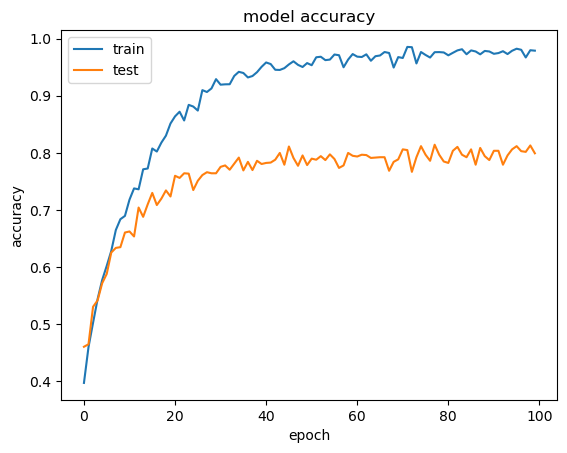

In [13]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

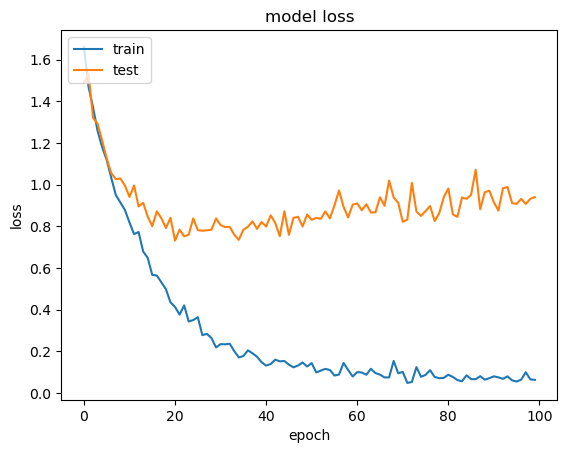

In [14]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
model.evaluate(X_test ,y_test)

63/63 [==============================] - 2s 38ms/step - loss: 0.8667 - accuracy: 0.8098


[0.8667397499084473, 0.8098098039627075]

In [16]:
model.save('Genre_classification_LSTM.h5')

***Impelementation of BiLSTM***

In [17]:
model_1 = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.LSTM(128,return_sequences=True,input_shape=[None,130,13])),
  keras.layers.LayerNormalization(),
  keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
  keras.layers.LayerNormalization(),
  keras.layers.Bidirectional(keras.layers.LSTM(32)),
  keras.layers.Dense(10, activation="softmax")
])

model_1.compile(loss ='sparse_categorical_crossentropy', optimizer = 'rmsprop' , metrics = ['accuracy'])

In [18]:
model_1.build(input_shape=[None,130,13])

In [19]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 130, 256)          145408    
_________________________________________________________________
layer_normalization_2 (Layer (None, 130, 256)          512       
_________________________________________________________________
bidirectional_1 (Bidirection (None, 130, 128)          164352    
_________________________________________________________________
layer_normalization_3 (Layer (None, 130, 128)          256       
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 10)                650       
Total params: 352,394
Trainable params: 352,394
Non-trainable params: 0
________________________________________________

In [20]:
history = model_1.fit(X_train , y_train , validation_data=(X_valid , y_valid) , epochs=100 , batch_size=8)

Epoch 1/100
799/799 [==============================] - 86s 107ms/step - loss: 1.5649 - accuracy: 0.4429 - val_loss: 1.3482 - val_accuracy: 0.5038
Epoch 2/100
799/799 [==============================] - 78s 97ms/step - loss: 1.2857 - accuracy: 0.5376 - val_loss: 1.3013 - val_accuracy: 0.5426
Epoch 3/100
799/799 [==============================] - 86s 108ms/step - loss: 1.1709 - accuracy: 0.5809 - val_loss: 1.1439 - val_accuracy: 0.6095
Epoch 4/100
799/799 [==============================] - 94s 118ms/step - loss: 1.0734 - accuracy: 0.6197 - val_loss: 1.1100 - val_accuracy: 0.6183
Epoch 5/100
799/799 [==============================] - 92s 116ms/step - loss: 0.9863 - accuracy: 0.6513 - val_loss: 1.0623 - val_accuracy: 0.6370
Epoch 6/100
799/799 [==============================] - 92s 116ms/step - loss: 0.9049 - accuracy: 0.6859 - val_loss: 1.0395 - val_accuracy: 0.6458
Epoch 7/100
799/799 [==============================] - 91s 113ms/step - loss: 0.8626 - accuracy: 0.7030 - val_loss: 0.9621 - 

In [21]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


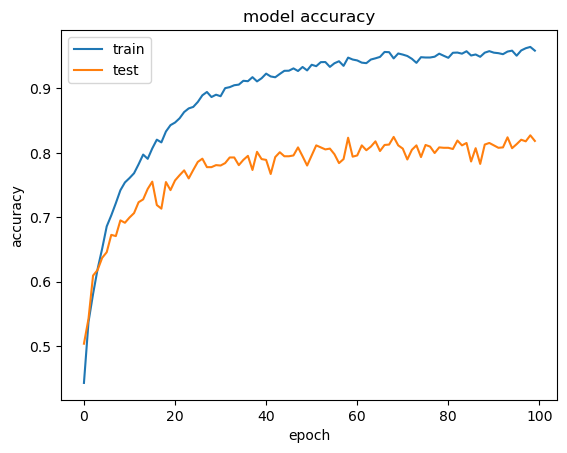

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

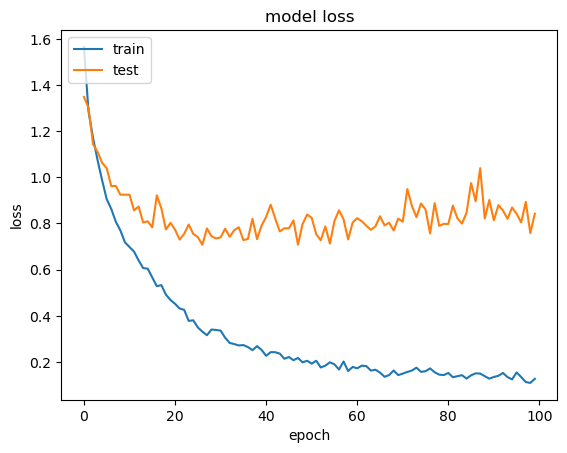

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [24]:
model_1.evaluate(X_test ,y_test)

63/63 [==============================] - 3s 47ms/step - loss: 0.8669 - accuracy: 0.8213


[0.8668915033340454, 0.8213213086128235]

***Attention Model***

In [25]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences

        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1),initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1))
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)
    
#------------------------------------------------------------------------------------------------------------------------------------------





In [26]:
model_2 = keras.models.Sequential([
  keras.layers.Bidirectional(keras.layers.LSTM(128,return_sequences=True,input_shape=[None,130,13])),
  keras.layers.LayerNormalization(),
  attention(return_sequences = True),
  keras.layers.LayerNormalization(),
  keras.layers.Bidirectional(keras.layers.LSTM(64,return_sequences=True)),
  keras.layers.LayerNormalization(),
  keras.layers.Bidirectional(keras.layers.LSTM(32)),
  keras.layers.Dense(10, activation="softmax")
])

model_2.compile(loss ='sparse_categorical_crossentropy', optimizer = 'rmsprop' , metrics = ['accuracy'])

In [27]:
model_2.build(input_shape=[None,130,13])

In [28]:
model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 130, 256)          145408    
_________________________________________________________________
layer_normalization_4 (Layer (None, 130, 256)          512       
_________________________________________________________________
attention (attention)        (None, 130, 256)          386       
_________________________________________________________________
layer_normalization_5 (Layer (None, 130, 256)          512       
_________________________________________________________________
bidirectional_4 (Bidirection (None, 130, 128)          164352    
_________________________________________________________________
layer_normalization_6 (Layer (None, 130, 128)          256       
_________________________________________________________________
bidirectional_5 (Bidirection (None, 64)               

In [29]:
history = model_2.fit(X_train , y_train , validation_data=(X_valid , y_valid) , epochs=100 , batch_size=8)

Epoch 1/100
799/799 [==============================] - 84s 105ms/step - loss: 1.5112 - accuracy: 0.4573 - val_loss: 1.2956 - val_accuracy: 0.5401
Epoch 2/100
799/799 [==============================] - 81s 102ms/step - loss: 1.2064 - accuracy: 0.5685 - val_loss: 1.1562 - val_accuracy: 0.6051
Epoch 3/100
799/799 [==============================] - 79s 99ms/step - loss: 1.0770 - accuracy: 0.6199 - val_loss: 1.1838 - val_accuracy: 0.5957
Epoch 4/100
799/799 [==============================] - 84s 106ms/step - loss: 0.9858 - accuracy: 0.6549 - val_loss: 1.0740 - val_accuracy: 0.6358
Epoch 5/100
799/799 [==============================] - 80s 100ms/step - loss: 0.9179 - accuracy: 0.6836 - val_loss: 0.9809 - val_accuracy: 0.6715
Epoch 6/100
799/799 [==============================] - 80s 100ms/step - loss: 0.8553 - accuracy: 0.7069 - val_loss: 0.9243 - val_accuracy: 0.6896
Epoch 7/100
799/799 [==============================] - 79s 99ms/step - loss: 0.7994 - accuracy: 0.7260 - val_loss: 0.9603 - v

In [30]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


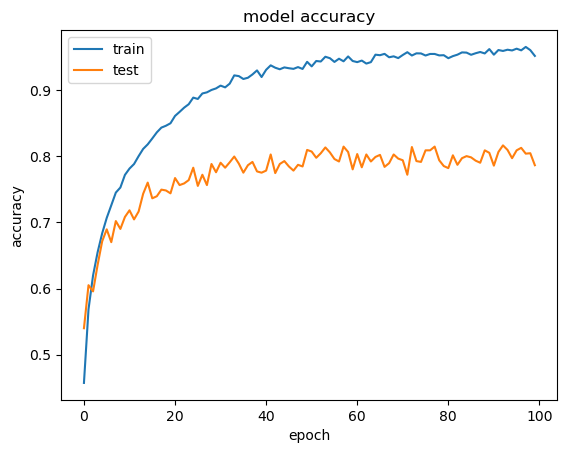

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

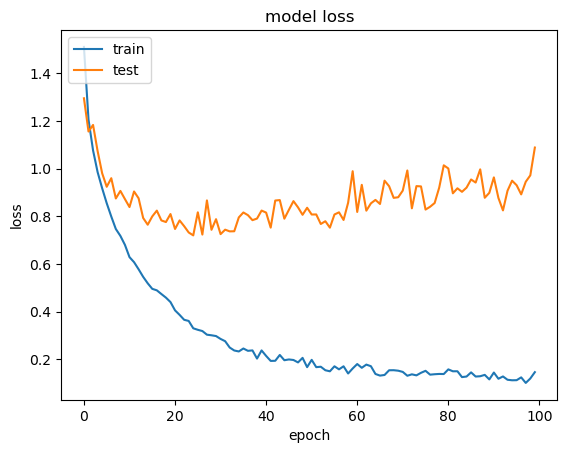

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model_2.evaluate(X_test ,y_test)

63/63 [==============================] - 4s 59ms/step - loss: 1.0012 - accuracy: 0.8038


[1.0012226104736328, 0.8038038015365601]